In [178]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_csv(r'C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\data\classification_metrics.csv', index_col = 'Unnamed: 0')
conf_df = df[['False_Positive_Count_regr_2',
       'False_Negative_Count_regr_2', 'True_Positive_Count_regr_2',
       'True_Negative_Count_regr_2', 'False_Positive_Count_rf',
       'False_Negative_Count_rf', 'True_Positive_Count_rf',
       'True_Negative_Count_rf']].copy()

cols = ['fp', 'fn', 'tp', 'tn']
concat = pd.concat([conf_df.iloc[:,:4].rename(columns = {conf_df.columns[i]:cols[i] for i in range(4)}), conf_df.iloc[:,4:].rename(columns = {conf_df.columns[i+4]:cols[i] for i in range(4)})])
concat['classifier'] = ['lr']* len(conf_df) + ['rf']* len(conf_df)
concat.head()

,fp,fn,tp,tn,classifier
phenotype,20,5,197,30,lr
phen_data,38,13,152,49,lr
morph,31,16,142,63,lr
phen_proc,13,15,131,93,lr
imaging,6,24,76,146,lr


In [68]:
# model the f1 score for each of the categories for each of the classifiers

total = concat.iloc[:,:4].sum(axis = 1)[0]
with pm.Model() as m:

    p_fp = pm.Beta('p_fp', 1,1, shape = len(concat))
    p_fn = pm.Beta('p_fn', 1,1, shape = len(concat))
    p_tp = pm.Beta('p_tp', 1,1, shape = len(concat))

    
    fp = pm.Binomial('fp', total, p = p_fp, observed = concat.iloc[:,0] )
    fn = pm.Binomial('fn', total, p = p_fn, observed = concat.iloc[:,1] )
    tp = pm.Binomial('tp', total, p = p_tp, observed = concat.iloc[:,2] )

    f1_score = pm.Deterministic('f1_score', (2 * tp) / (2* tp + fp + fn))

    trace = pm.sample()

C:\Users\conix\AppData\Local\Temp\ipykernel_112076\532490742.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total = concat.iloc[:,:4].sum(axis = 1)[0]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_fp, p_fn, p_tp]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1155 seconds.


In [192]:
# get posterior predictive samples to get an idea of the f1 scores we should expect to see

with m:
    ppc = pm.sample_posterior_predictive(trace, var_names = ['f1_score', 'tp', 'fp', 'fn'])


Sampling: [fn, fp, tp]


Output()

C:\Users\conix\.conda\envs\TM_env\lib\site-packages\pytensor\scalar\basic.py:1982: RuntimeWarning: invalid value 
encountered in divide
  return x / y

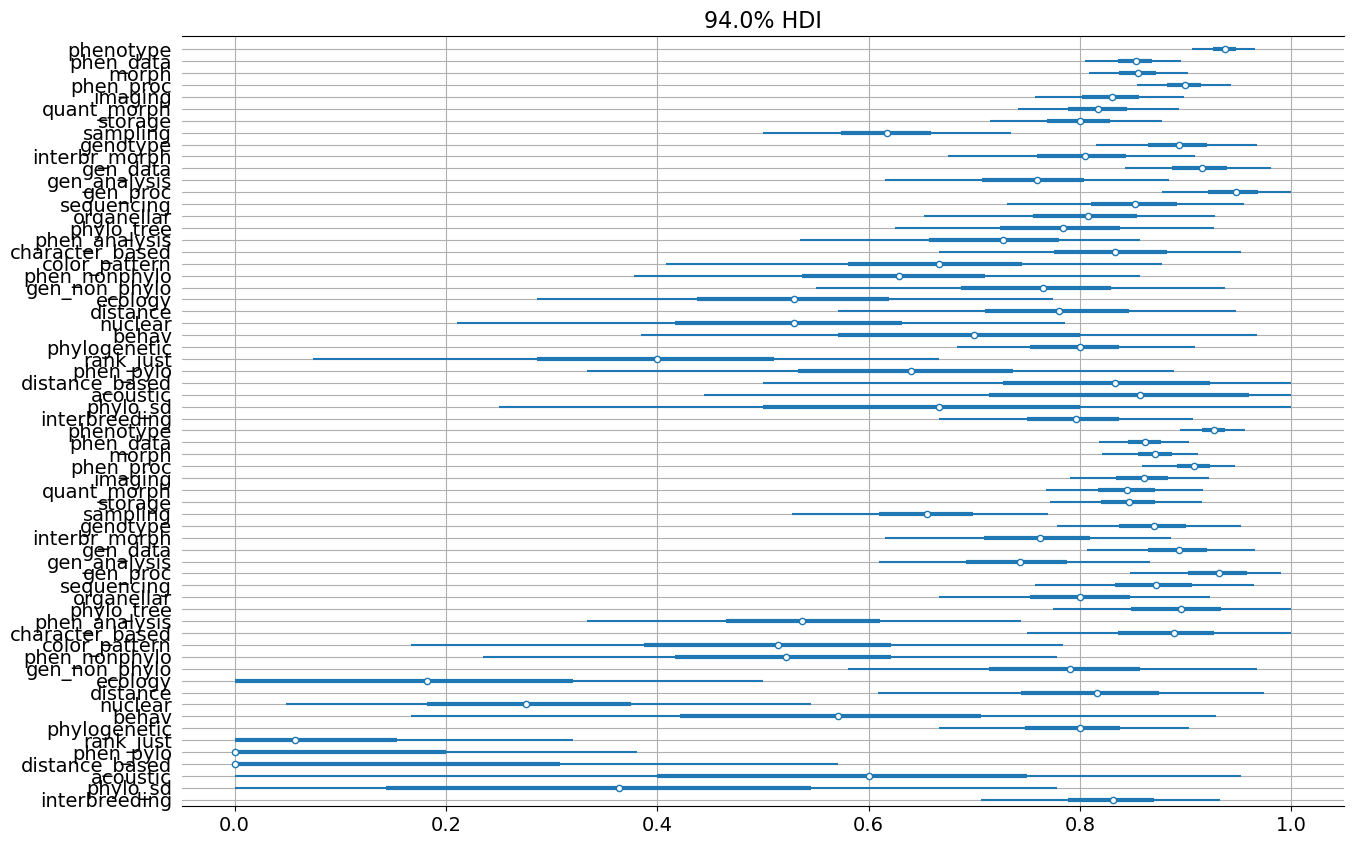

In [173]:
# for each of the labels, deduct the expected f1 scores for each of the classifiers

f1_score = ppc.posterior_predictive['f1_score']

# check for non finite results, as there might have been divisions by zero in the ppc calculations of f1
# replace them by the mean for that dimension
mean_values = f1_score.mean(axis = (0,1))
# Replace non-finite values with the mean for that dimension
f1_cleaned = f1_score.copy()  # Copy the DataArray to avoid modifying the original
f1_cleaned = f1_cleaned.where(np.isfinite(f1_cleaned), other=mean_values)

# now plot
labels = list(concat.index)
labels.reverse()

fig, ax = plt.subplots(figsize = (15,10))
az.plot_forest(f1_cleaned, combined = True, ax=ax)
ax.set_yticklabels(labels)
ax.grid(True)
plt.show()


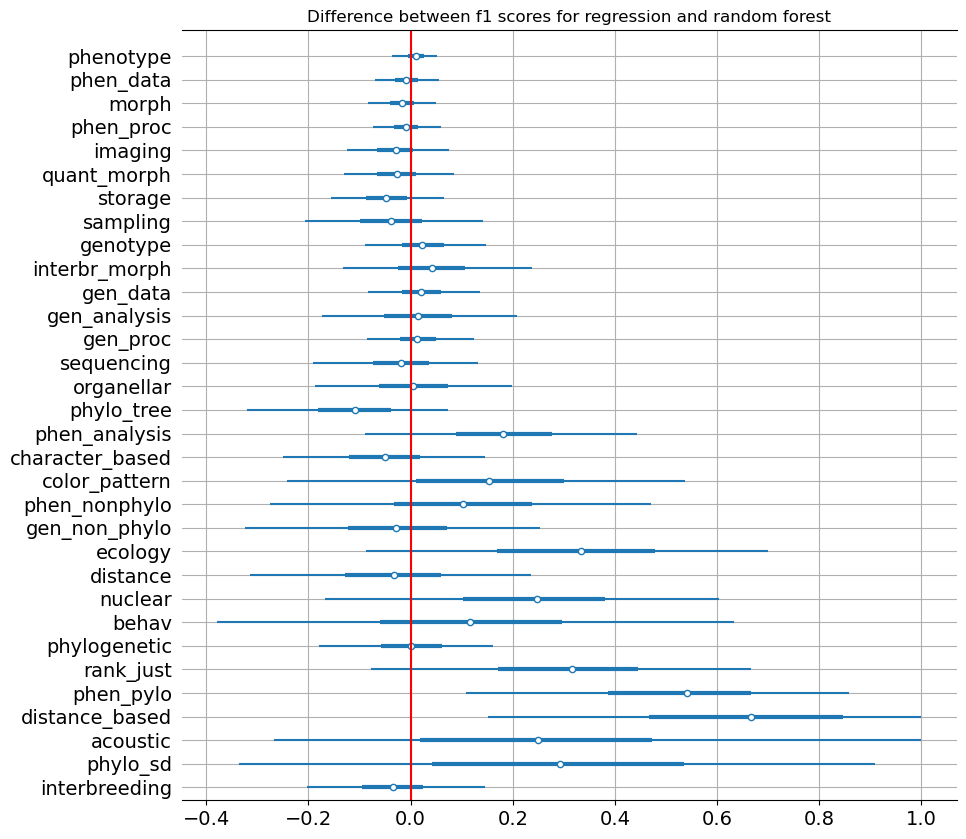

In [174]:
# now compare f1 scores
# Select the first half (0-31) and the second half (32-63)
first_half = f1_cleaned[:, :, :32]
second_half = f1_cleaned[:, :, 32:]

# Subtract the second half from the first half along the last dimension
result = xr.DataArray(
    first_half.values - second_half.values,  # Perform explicit subtraction
    dims=first_half.dims,  # Use the same dimensions as the original DataArray
    coords=first_half.coords,  # Use the same coordinates for consistency
)

labels = list(concat.iloc[:32,:].index)
labels.reverse()

fig, ax = plt.subplots(figsize = (10,10))
az.plot_forest(result, combined = True, ax=ax)
ax.set_yticklabels(labels)
ax.axvline(0, color = 'r')
ax.grid(True)
ax.set_title('Difference between f1 scores for regression and random forest')
plt.show()

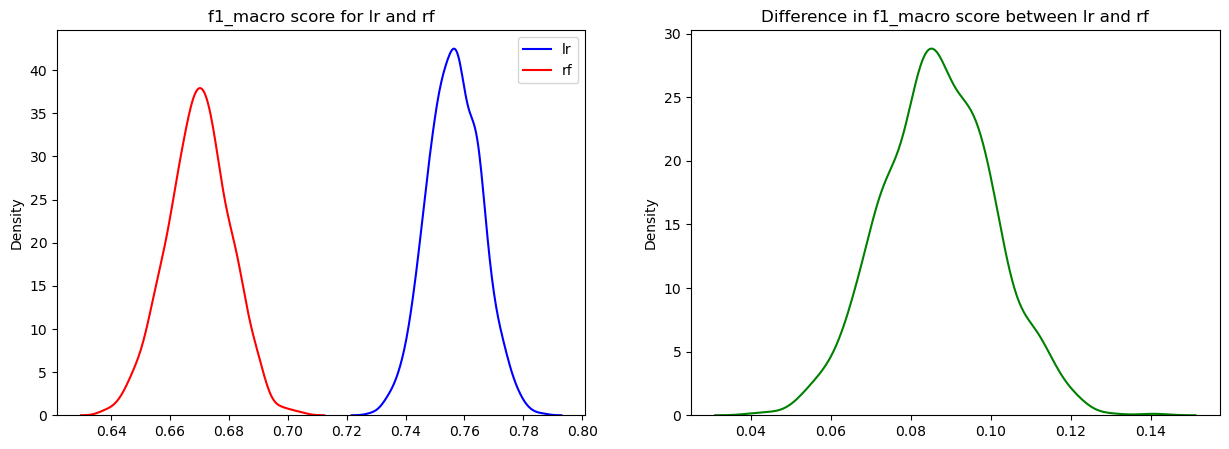

In [189]:
# average over the f1 scores for the separate categories to get the expected f1_macro
# deduct these from each other to get the expected difference

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))

sns.kdeplot(first_half.mean(axis = (0,2)), color = 'b', ax= ax[0])
sns.kdeplot(second_half.mean(axis = (0,2)), color = 'r', ax= ax[0])
ax[0].legend(['lr', 'rf'])
ax[0].set_title('f1_macro score for lr and rf')

sns.kdeplot(first_half.mean(axis = (0,2)) - second_half.mean(axis = (0,2)), color = 'g', ax= ax[1])
ax[1].set_title('Difference in f1_macro score between lr and rf')
plt.show()

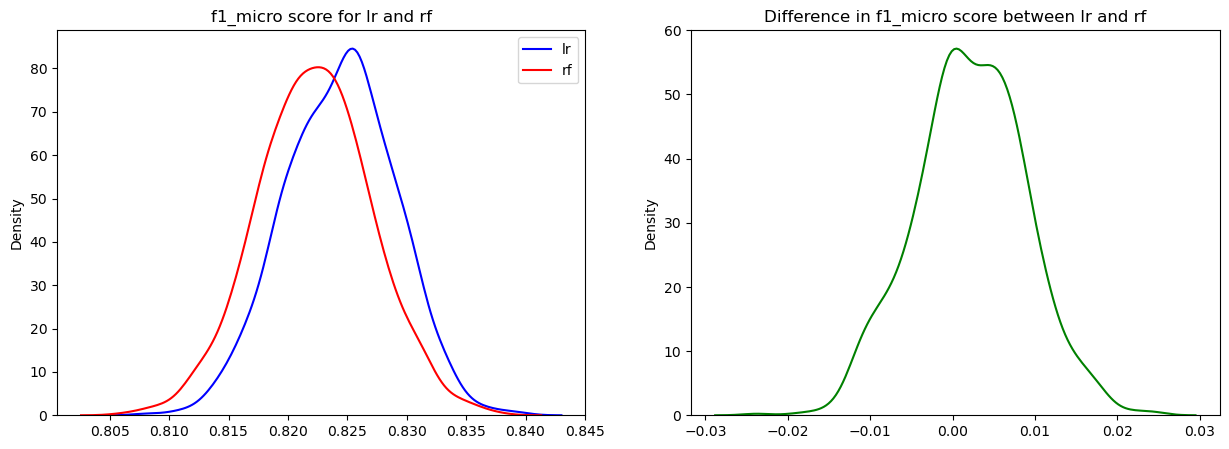

In [202]:
# f1 micro

# sum the fp, tp and fn to get global counts
tp_global_lr = ppc['posterior_predictive']['tp'][:,:,:32].sum(axis = (2))
fp_global_lr = ppc['posterior_predictive']['fp'][:,:,:32].sum(axis = (2))
fn_global_lr = ppc['posterior_predictive']['fn'][:,:,:32].sum(axis = (2))

tp_global_rf = ppc['posterior_predictive']['tp'][:,:,32:].sum(axis = (2))
fp_global_rf = ppc['posterior_predictive']['fp'][:,:,32:].sum(axis = (2))
fn_global_rf = ppc['posterior_predictive']['fn'][:,:,32:].sum(axis = (2))

# Calculate F1-micro
precision_global_lr = tp_global_lr / (tp_global_lr + fp_global_lr)
recall_global_lr = tp_global_lr / (tp_global_lr + fn_global_lr)
f1_micro_lr = 2 * (precision_global_lr * recall_global_lr) / (precision_global_lr + recall_global_lr)

precision_global_rf = tp_global_rf / (tp_global_rf + fp_global_rf)
recall_global_rf = tp_global_rf / (tp_global_rf + fn_global_rf)
f1_micro_rf = 2 * (precision_global_rf * recall_global_rf) / (precision_global_rf + recall_global_rf)

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))

sns.kdeplot(f1_micro_lr.mean(axis = 0), color = 'b', ax= ax[0])
sns.kdeplot(f1_micro_rf.mean(axis = 0), color = 'r', ax= ax[0])
ax[0].legend(['lr', 'rf'])
ax[0].set_title('f1_micro score for lr and rf')

sns.kdeplot(f1_micro_lr.mean(axis = 0) - f1_micro_rf.mean(axis = 0), color = 'g', ax= ax[1])
ax[1].set_title('Difference in f1_micro score between lr and rf')
plt.show()